In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from feature_engine.datetime import DatetimeFeatures
import joblib
import matplotlib.pyplot as plt

In [3]:
pd.set_option("display.max_columns",None)

In [4]:
sklearn.set_config(transform_output="default")

In [5]:
train_df=pd.read_csv("data/train.csv")
val_df=pd.read_csv("data/val.csv")
test_df=pd.read_csv("data/test.csv")

### Split the Data

In [6]:
def split_data(data):
	X = data.drop(columns="price")
	y = data.price.copy()
	return (X, y)

In [7]:
X_train, y_train = split_data(train_df)

In [8]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Indigo,2019-05-21,Kolkata,Banglore,17:15:00,19:50:00,155,0.0,No Info
1,Indigo,2019-05-09,Delhi,Cochin,23:30:00,04:35:00,305,1.0,No Info
2,Indigo,2019-03-03,Chennai,Kolkata,05:15:00,07:35:00,140,0.0,No Info
3,Jet Airways,2019-05-12,Kolkata,Banglore,06:30:00,04:40:00,1330,1.0,In-flight meal not included
4,Indigo,2019-05-15,Banglore,Delhi,18:55:00,21:50:00,175,0.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-06-01,Delhi,Cochin,19:45:00,04:25:00,520,1.0,No Info
636,Indigo,2019-03-24,Kolkata,Banglore,15:10:00,20:15:00,305,1.0,No Info
637,Indigo,2019-05-18,Delhi,Cochin,04:55:00,21:00:00,965,1.0,No Info
638,Jet Airways,2019-06-27,Delhi,Cochin,20:55:00,19:00:00,1325,1.0,In-flight meal not included


In [9]:
y_train

0       4804
1       8177
2       6482
3       8586
4       4823
       ...  
635    14714
636     6762
637     6758
638    10262
639    13941
Name: price, Length: 640, dtype: int64

In [10]:
X_val, y_val = split_data(val_df)

print(X_val.shape, y_val.shape)

(160, 9) (160,)


In [11]:
X_test, y_test = split_data(test_df)

print(X_test.shape, y_test.shape)

(200, 9) (200,)


### Meta-info

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


 ###   Data Preprocessing

In [13]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]

num_cols = ["duration", "total_stops"]

cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [14]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [15]:
num_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
	("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
	("scaler", StandardScaler())
])

In [16]:
preprocessor = ColumnTransformer(transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols),
	("doj", doj_transformer, ["date_of_journey"]),
	("time", time_transformer, ["dep_time", "arrival_time"])
])

In [17]:
preprocessor.fit_transform(X_train)

array([[-1.02648936, -1.33053482,  0.        , ..., -0.51907378,
         0.86071314,  1.53372714],
       [-0.73601204,  0.15817547,  0.        , ...,  0.29716017,
        -1.32060844,  0.60828524],
       [-1.05553709, -1.33053482,  0.        , ..., -0.51907378,
        -0.88434412,  0.60828524],
       ...,
       [ 0.54208817,  0.15817547,  0.        , ...,  1.65755009,
         1.15155602, -1.55107917],
       [ 1.23923374,  0.15817547,  0.        , ...,  1.65755009,
         0.86071314, -1.55107917],
       [-0.4552173 ,  0.15817547,  0.        , ..., -0.79115176,
        -1.32060844,  0.91676587]])

In [18]:
preprocessor.fit_transform(X_train).shape

(640, 34)

### Model Selection

In [19]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}

In [20]:
data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [21]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [22]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)
    
	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

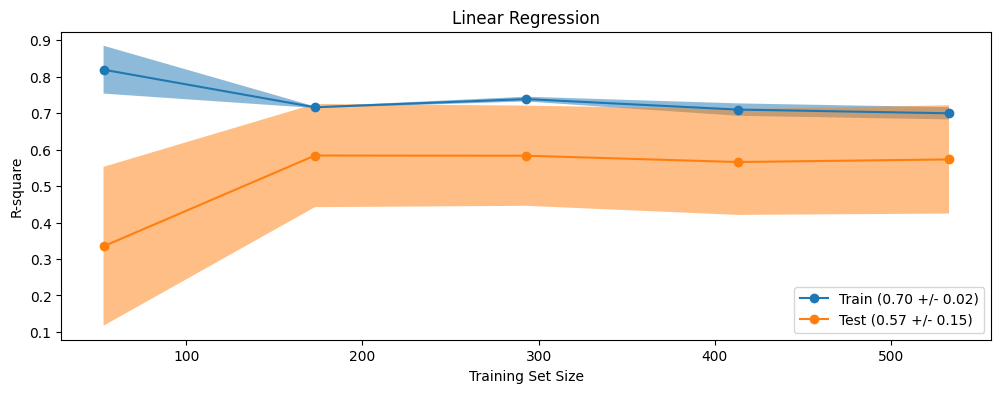

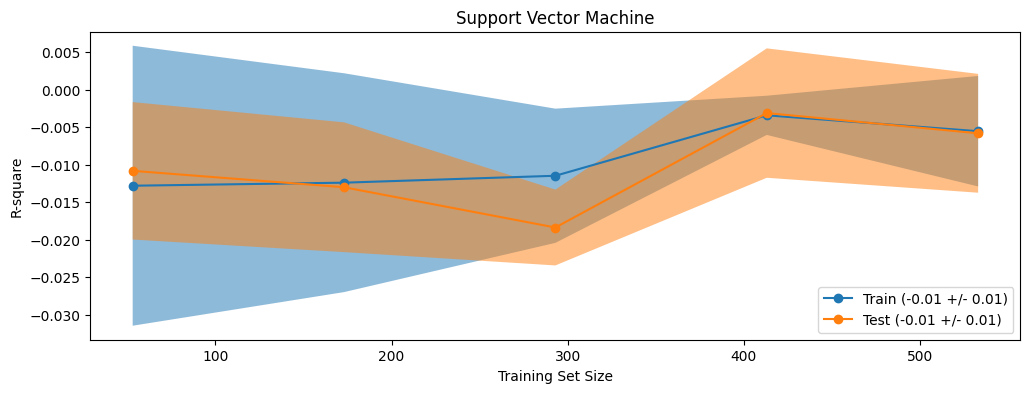

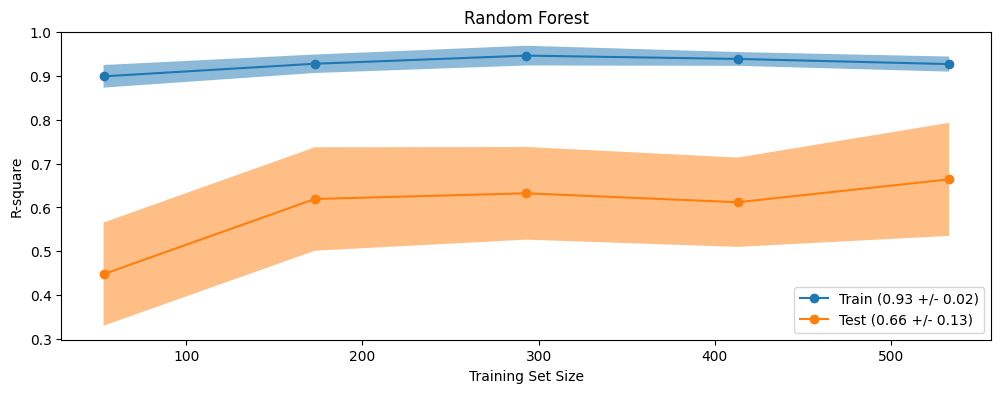

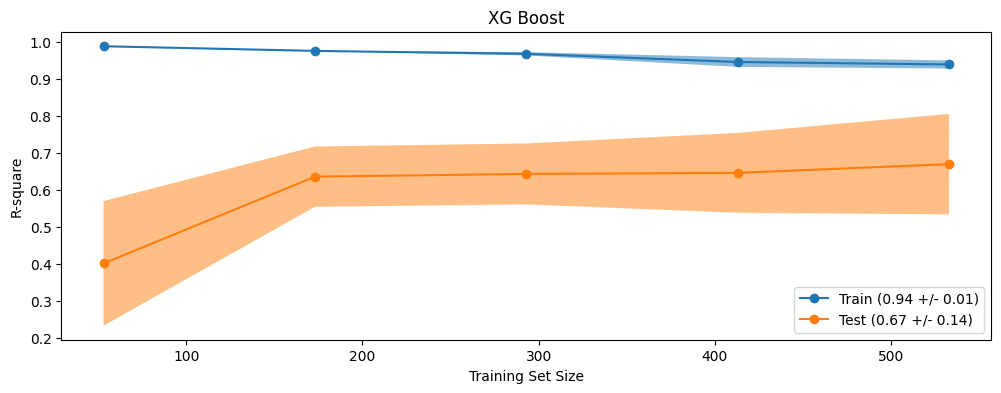

In [23]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

In [24]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [25]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

 ### Model Evaluation

In [26]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [27]:
print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")


R2 score on Training data is = 0.941501357819248


In [28]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")


R2 score on Test data is = 0.5709321065800913


### Model Persistence

In [29]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [30]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [31]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.5709321065800913

In [1]:
pip show scikit-learn


Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: 
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIB